# Modelado con SVM (Support Vector Machine)

## Preparación de información para el modelo

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [2]:
#leer csv
df = pd.read_csv('defunciones_clean.csv')

### Manejo de columnas y balanceo en causas de defunción

- Eliminación de columnas irrelevantes para el modelo

In [3]:
# Eliminar columnas no relevantes (segun analisis exploratorio anteriormente realizado)
df.drop('Departamento_Registro', axis=1, inplace=True)
df.drop('Municipio_Registro', axis=1, inplace=True)

df.drop('Municipio_Ocurrencia', axis=1, inplace=True)   
df.drop('Departamento_Residencia_Madre', axis=1, inplace=True) 

df.drop('Municipio_Residencia_Madre', axis=1, inplace=True)
df.drop('Departamento_Ocurrencia', axis=1, inplace=True)

df.drop('Año_Ocurrencia', axis=1, inplace=True)
df.drop('Mes_Ocurrencia', axis=1, inplace=True)
df.drop('Día_Ocurrencia', axis=1, inplace=True)        # No se considera el día de ocurrencia

df.drop('Año_Registro', axis=1, inplace=True)
df.drop('Mes_Registro', axis=1, inplace=True)

df = df[df.Causa_Defunción != 99]

df.head()

,Área_Geográfica,Asistencia_Recibida,Causa_Defunción,Clase_Parto,Edad_Madre,Estado_Civil_Madre,Escolaridad_Madre,Ocupación_Madre,Semanas_Gestacion,Sexo,Sitio_Ocurrencia,Tipo_Atencion,Total_Hijos_Nacidos,Total_Hijos_Nacidos_Muertos,Total_Hijos_Vivos,Via_Parto,Nacionalidad_Madre,Grupo_Etnico_Madre
0,99,6,0,1,18.0,2,99,99,34.416349,1,2,1,1.269311,2.0,1.0,99,1,4
1,99,1,0,1,36.0,2,99,1,34.416349,1,9,1,1.269311,3.0,2.0,99,1,4
2,99,2,0,1,22.0,2,99,99,34.416349,1,2,1,1.269311,3.0,2.0,99,1,4
3,99,2,0,1,26.0,2,99,99,34.416349,1,2,1,1.269311,0.0,0.0,99,1,4
4,99,2,0,1,43.0,2,99,99,34.416349,2,2,1,1.269311,10.0,6.0,99,1,4


- Balanceo de clases en causas de defunción

In [4]:
from imblearn.over_sampling import RandomOverSampler

x = df.drop('Causa_Defunción', axis=1)
y = df['Causa_Defunción']

balance = RandomOverSampler(sampling_strategy='minority')
x_balance, y_balance = balance.fit_resample(x, y)

df = pd.concat([x_balance, y_balance], axis=1)

print('Cantidad de registros por causa de defunción: ')
print(df['Causa_Defunción'].value_counts())

Cantidad de registros por causa de defunción: 
0    35271
1    35271
Name: Causa_Defunción, dtype: int64


- Separar en entrenaminto y prueba

In [5]:
print('Cantidad de registros: ', len(df))

X = df.drop("Causa_Defunción", axis=1)
Y = df["Causa_Defunción"]

#dividir el dataset en conjunto de entrenamiento y conjunto de testing
X_entreno, X_prueba, y_entreno, y_prueba = train_test_split(X, Y, test_size=0.3, random_state=42)
X_prueba, X_val, y_prueba, y_val = train_test_split(X_prueba, y_prueba, test_size=0.5, random_state=42)

print('Cantidad de registros de entrenamiento: ', len(X_entreno))
print('Cantidad de registros de prueba: ', len(X_prueba))

df.head()



Cantidad de registros:  70542
Cantidad de registros de entrenamiento:  49379
Cantidad de registros de prueba:  10581


,Área_Geográfica,Asistencia_Recibida,Clase_Parto,Edad_Madre,Estado_Civil_Madre,Escolaridad_Madre,Ocupación_Madre,Semanas_Gestacion,Sexo,Sitio_Ocurrencia,Tipo_Atencion,Total_Hijos_Nacidos,Total_Hijos_Nacidos_Muertos,Total_Hijos_Vivos,Via_Parto,Nacionalidad_Madre,Grupo_Etnico_Madre,Causa_Defunción
0,99,6,1,18.0,2,99,99,34.416349,1,2,1,1.269311,2.0,1.0,99,1,4,0
1,99,1,1,36.0,2,99,1,34.416349,1,9,1,1.269311,3.0,2.0,99,1,4,0
2,99,2,1,22.0,2,99,99,34.416349,1,2,1,1.269311,3.0,2.0,99,1,4,0
3,99,2,1,26.0,2,99,99,34.416349,1,2,1,1.269311,0.0,0.0,99,1,4,0
4,99,2,1,43.0,2,99,99,34.416349,2,2,1,1.269311,10.0,6.0,99,1,4,0


## Creación del modelo SVM

Se utiiza GridSearchCV para determinar que hiperparámetros son los más óptimos para el respectivo modelo.

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm
import matplotlib.pyplot as plt

params = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf', 'linear', 'sigmoid', 'poly']
}

svm_dummy = svm.SVC()

# smaller sample size for grid search, since it is an exhaustive process and it takes a lot of time
X_entreno_sample = X_entreno.sample(frac=0.001, random_state=100)
y_entreno_sample = y_entreno.sample(frac=0.001, random_state=100)

svm_grid = GridSearchCV(svm_dummy, params, n_jobs=-1, verbose=2, cv=3)

In [7]:
svm_grid.fit(X_entreno_sample, y_entreno_sample) 

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

print("Grid search results:")
print("---------------------")
results = svm_grid.cv_results_
print(svm_grid.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .......................C=0.1, gamma=0

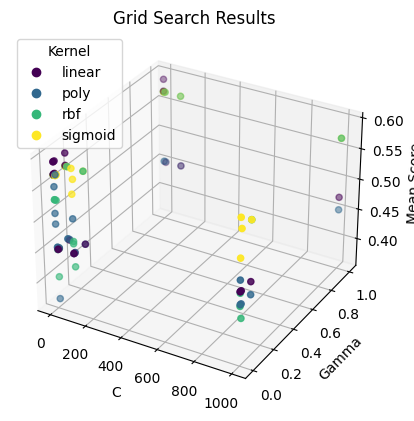

Best parameters set found on development set:
{'C': 1, 'gamma': 1, 'kernel': 'linear'}


In [8]:
mean_scores = results["mean_test_score"]
params = results["params"]

# Extract parameter values for each parameter
param_C = [param['C'] for param in params]
param_gamma = [param['gamma'] for param in params]
param_kernel = [param['kernel'] for param in params]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Mapping kernel names to integer values
kernel_map = {'linear': 0, 'poly': 1, 'rbf': 2, 'sigmoid': 3}
kernel_colors = [kernel_map[kernel] for kernel in param_kernel]

# Plotting the mean scores with color-coded markers based on kernel
scatter = ax.scatter(param_C, param_gamma, mean_scores, c=kernel_colors, cmap='viridis')

ax.set_xlabel('C')
ax.set_ylabel('Gamma')
ax.set_zlabel('Mean Score')
ax.set_title('Grid Search Results')
ax.legend(handles=scatter.legend_elements()[0], labels=kernel_map.keys(), title='Kernel')

plt.show()

print("Best parameters set found on development set:")
print(svm_grid.best_params_)


* _Debido al gran tamaño del dataset y de la alta complejidad de ejeución del gridsearch, se decidió realizar el gridsearch en una muestra del 0.5% del dataset original._
* _Existen múltiples hiper-parámetros que alcanzan el mismo score, por lo que se decidió escoger los que menos tiempo de ejecución requirieran._

In [9]:
from sklearn.metrics import accuracy_score , recall_score, precision_score, f1_score

# Crear el clasificador SVM
clf = svm.SVC(kernel='linear')  # Puedes ajustar el kernel según tus necesidades (lineal, polinómico, RBF, etc.)

# Entrenar el modelo utilizando los datos de entrenamiento
clf.fit(X_entreno, y_entreno)

# Realizar predicciones en el conjunto de prueba
predicciones = clf.predict(X_prueba)

# Calcular el accuracy
accuracy = accuracy_score(y_prueba, predicciones)

# Mostrar el accuracy
print("Accuracy:", accuracy)
print("Recall:", recall_score(y_prueba, predicciones, average='weighted'))
#print("Precision:", precision_score(y_prueba, predicciones, average='weighted'))
#print("F1:", f1_score(y_prueba, predicciones, average='weighted'))

Accuracy: 0.5772611284377658
Recall: 0.5772611284377658


In [10]:
# Se utilizan los hipérparámetros obtenidos en la búsqueda de grilla
clf = svm.SVC(kernel='rbf', C=1, gamma=0.1)  

# Entrenar el modelo utilizando los datos de entrenamiento
clf.fit(X_entreno, y_entreno)

# Realizar predicciones en el conjunto de prueba
predicciones = clf.predict(X_prueba)

# Calcular el accuracy
accuracy = accuracy_score(y_prueba, predicciones)

# Mostrar el accuracy
print("Accuracy:", accuracy)
print("Recall:", recall_score(y_prueba, predicciones, average='weighted'))
print("Precision:", precision_score(y_prueba, predicciones, average='weighted'))
print("F1:", f1_score(y_prueba, predicciones, average='weighted'))

Accuracy: 0.9665438049333711
Recall: 0.9665438049333711
Precision: 0.9675284559414634
F1: 0.9665384257364342


In [11]:
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(y_prueba, predicciones)

print("Confusion Matrix:")
print(confusion_mat)

Confusion Matrix:
[[5076  297]
 [  57 5151]]


* _Podemos apreciar que el cambio a los hiperparámetros representa un gran cambio en el score del modelo, por lo que se confirma que los hiperparámetros escogidos son los más óptimos; el accuracy y el recall están por encima del 0.93, lo cual es un buen resultado._

## Impacto de las diferentes variables en el rendimiento del modelo

* _En este acercamiento, se busca observar las variables más implicadas en las condiciones de vida de la madre en vez del desarrollo del embarazo como tal. Con esto, buscamos encontrar el impacto que tienen las condiciones de vida de la madre en el resultado del embarazo._

In [12]:
columnas = X.columns.tolist()
causas = [0, 1] # 0 = Parto, 1 = Embarazo
disparidad = {}

### Escolaridad de la madre

In [13]:
df0 = df[df['Causa_Defunción'] == 0]
df1 = df[df['Causa_Defunción'] == 1]

In [14]:
# Causa de defunción = 0 = Parto
print(len(df0['Escolaridad_Madre']))
df0['Escolaridad_Madre'].value_counts()

35271


1     10999
2     10369
99     6113
3      3991
4      3303
5       493
6         3
Name: Escolaridad_Madre, dtype: int64

In [15]:
# Causa de defunción = 1 = Embarazo
print(len(df1['Escolaridad_Madre']))
df1['Escolaridad_Madre'].value_counts()

35271


2     13366
1      9989
3      5056
4      3035
99     2882
5       943
Name: Escolaridad_Madre, dtype: int64

* _En relación a la escolaridad de la madre, hay una mayor persistencia de defunciones durante el parto en madres con ninguna educación o con educación primaria._
* _Por otro lado, las defunciones fetales durante el embarazo son más persistentes en madres con primaria._
* _Debido a esto, podemos ver una tendencia a mayor mortalidad en madres con menor nivel de educación._

In [16]:
# Nivel de educación de la madre - Universidad

niveles_edu = [4, 5, 6]

for n in niveles_edu:
    disparidad[n] = {}
    for c in causas:
        df_1 = df[df['Causa_Defunción'] == c] # causa de defunción
        df_1 = df_1[columnas + ['Causa_Defunción']]

        df_1['Escolaridad_Madre'] = n # Universidad

        x_train, x_test, y_train, y_test = train_test_split(df_1.drop('Causa_Defunción', axis=1), df_1['Causa_Defunción'], test_size=0.3, random_state=42)
        y_correct = clf.predict(x_test)

        print("---------------------------------------------------------------------------")
        causa = ''
        if c == 0:
            causa = 'Parto'
        elif c == 1:
            causa = 'Embarazo'

        educacion = ''
        if n == 4:
            educacion = 'Básico'
        elif n == 5:
            educacion = 'Universidad'
        elif n == 6:
            educacion = 'Postgrado'

        print("Causa de defunción: ", causa)
        print("Nivel de educación de la madre: ", educacion)
        
        print('Predicción: ', y_correct)
        print('Realidad: ', y_test.values)
        cambio = (y_correct != y_test).sum() / len(y_test) * 100
        print("Cambio: ", cambio, "%")
        #disparidad[causa + ' - ' + educacion] = cambio
        disparidad[n][c] = cambio



---------------------------------------------------------------------------
Causa de defunción:  Parto
Nivel de educación de la madre:  Básico
Predicción:  [0 0 0 ... 0 0 0]
Realidad:  [0 0 0 ... 0 0 0]
Cambio:  2.6649026649026646 %
---------------------------------------------------------------------------
Causa de defunción:  Embarazo
Nivel de educación de la madre:  Básico
Predicción:  [0 0 0 ... 1 1 0]
Realidad:  [1 1 1 ... 1 1 1]
Cambio:  54.243054243054246 %
---------------------------------------------------------------------------
Causa de defunción:  Parto
Nivel de educación de la madre:  Universidad
Predicción:  [0 0 0 ... 0 0 0]
Realidad:  [0 0 0 ... 0 0 0]
Cambio:  1.5403515403515402 %
---------------------------------------------------------------------------
Causa de defunción:  Embarazo
Nivel de educación de la madre:  Universidad
Predicción:  [0 0 0 ... 0 1 0]
Realidad:  [1 1 1 ... 1 1 1]
Cambio:  73.99357399357399 %
-----------------------------------------------------

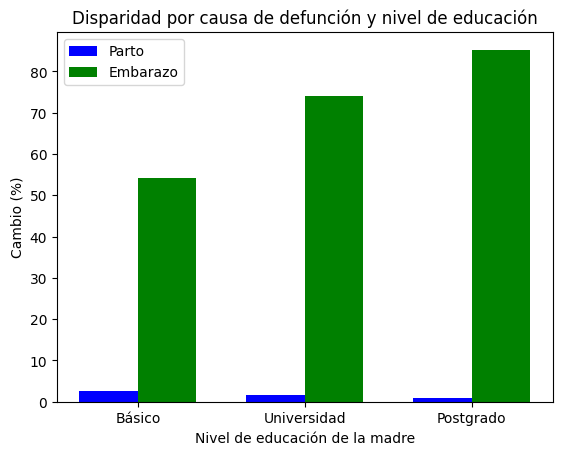

In [17]:
import numpy as np
import matplotlib.pyplot as plt

educations = ['Básico', 'Universidad', 'Postgrado']
parto_values = [disparidad[4][0], disparidad[5][0], disparidad[6][0]]
embarazo_values = [disparidad[4][1], disparidad[5][1], disparidad[6][1]]

bar_width = 0.35

r1 = np.arange(len(educations))
r2 = [x + bar_width for x in r1]

plt.bar(r1, parto_values, color='b', width=bar_width, label='Parto')
plt.bar(r2, embarazo_values, color='g', width=bar_width, label='Embarazo')

plt.xlabel('Nivel de educación de la madre')
plt.ylabel('Cambio (%)')
plt.title('Disparidad por causa de defunción y nivel de educación')
plt.xticks([r + bar_width / 2 for r in range(len(educations))], educations)
plt.legend()
plt.show()


### Total de hijos de la madre

In [18]:
df0 = df[df['Causa_Defunción'] == 0]
df1 = df[df['Causa_Defunción'] == 1]
df0['Total_Hijos_Vivos'] = np.round(df0['Total_Hijos_Vivos'])
df1['Total_Hijos_Vivos'] = np.round(df1['Total_Hijos_Vivos'])
df0['Total_Hijos_Vivos'] = df0['Total_Hijos_Vivos'].astype(int)
df1['Total_Hijos_Vivos'] = df1['Total_Hijos_Vivos'].astype(int)

/var/folders/wq/gs7vpwkj7k31lw9njy09srjw0000gn/T/ipykernel_21814/2508835345.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df0['Total_Hijos_Vivos'] = np.round(df0['Total_Hijos_Vivos'])
/var/folders/wq/gs7vpwkj7k31lw9njy09srjw0000gn/T/ipykernel_21814/2508835345.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Total_Hijos_Vivos'] = np.round(df1['Total_Hijos_Vivos'])
/var/folders/wq/gs7vpwkj7k31lw9njy09srjw0000gn/T/ipykernel_21814/2508835345.py:5: SettingWithCopyWarning: 
A value is trying to be s

* _La cantidad de hijos vivos resulta más relevante que la cantidad de hijos difuntos._

In [19]:
# Causa de defunción = 0 = Parto
print(len(df0['Total_Hijos_Vivos']))
df0['Total_Hijos_Vivos'].value_counts()

35271


3     16616
1      8049
2      4270
4      1748
5      1286
0       981
6       917
7       570
8       365
9       224
10      139
11       69
12       24
13       10
16        1
15        1
14        1
Name: Total_Hijos_Vivos, dtype: int64

In [20]:
# Causa de defunción = 1 = Embarazo
print(len(df1['Total_Hijos_Vivos']))
df1['Total_Hijos_Vivos'].value_counts()

35271


3     14692
1      9209
2      5574
4      1521
5      1433
6      1008
7       538
9       426
8       290
0       252
10      200
12       67
11       61
Name: Total_Hijos_Vivos, dtype: int64

* _El punto de cambio en la cantidad de hijos vivos se encuentra en 4 hijos vivos, donde se observa un cambio en la tendencia de la mortalidad._

In [21]:
# Nivel de educación de la madre - Universidad
from random import randint

num_hijos = {
    '0 a 4': (0, 4),
    '5 a 10': (5, 10),
    '10 o más': (10, 100)
}

disparidad = {}

"""i = 0
while i < 4:
    if i < 2:
        if '0 a 4' not in disparidad.keys():
            disparidad['0 a 4'] = {}
    else:
        if '5 a 10' not in disparidad.keys():
            disparidad['5 a 10'] = {}
    for c in causas:
        df_1 = df[df['Causa_Defunción'] == c] # causa de defunción
        df_1 = df_1[columnas + ['Causa_Defunción']]

        if i < 2:
            # random upsample
            n = randint(0, 4)
            df_1['Total_Hijos_Vivos'] = n 
        else:
            # random downsample
            n = randint(5, 10)
            df_1['Total_Hijos_Vivos'] = n

        #df_1['Escolaridad_Madre'] = n # Universidad

        x_train, x_test, y_train, y_test = train_test_split(df_1.drop('Causa_Defunción', axis=1), df_1['Causa_Defunción'], test_size=0.3, random_state=42)
        y_correct = clf.predict(x_test)

        print("---------------------------------------------------------------------------")
        causa = ''
        if c == 0:
            causa = 'Parto'
        elif c == 1:
            causa = 'Embarazo'


        print("Causa de defunción: ", causa)
        print("Cantidad de hijos vivos: ", n)
        
        print('Predicción: ', y_correct)
        print('Realidad: ', y_test.values)
        cambio = (y_correct != y_test).sum() / len(y_test) * 100
        #print("Cambio: ", (y_correct != y_test).sum() / len(y_test) * 100, "%")
        print("Cambio: ", cambio, "%")
    i += 1"""

for n in num_hijos.keys():
    disparidad[n] = {}
    ini, fin = num_hijos[n]
    for c in causas:
        df_1 = df[df['Causa_Defunción'] == c] # causa de defunción
        df_1 = df_1[columnas + ['Causa_Defunción']]
        df_1 = df_1[(df_1['Total_Hijos_Vivos'] >= ini) & (df_1['Total_Hijos_Vivos'] <= fin)]

        if len(df_1) == 0:
            continue

        x_train, x_test, y_train, y_test = train_test_split(df_1.drop('Causa_Defunción', axis=1), df_1['Causa_Defunción'], test_size=0.3, random_state=42)

        if len(x_train) == 0 or len(x_test) == 0:
            continue

        y_correct = clf.predict(x_test)

        print("---------------------------------------------------------------------------")
        causa = ''
        if c == 0:
            causa = 'Parto'
        elif c == 1:
            causa = 'Embarazo'

        print("Causa de defunción: ", causa)
        print("Cantidad de hijos vivos: ", n)

        print('Predicción: ', y_correct)
        print('Realidad: ', y_test.values)
        cambio = (y_correct != y_test).sum() / len(y_test) * 100
        #print("Cambio: ", (y_correct != y_test).sum() / len(y_test) * 100, "%")
        print("Cambio: ", cambio, "%")
        disparidad[n][c] = cambio



---------------------------------------------------------------------------
Causa de defunción:  Parto
Cantidad de hijos vivos:  0 a 4
Predicción:  [0 0 0 ... 0 0 0]
Realidad:  [0 0 0 ... 0 0 0]
Cambio:  4.8315789473684205 %
---------------------------------------------------------------------------
Causa de defunción:  Embarazo
Cantidad de hijos vivos:  0 a 4
Predicción:  [1 1 1 ... 1 1 1]
Realidad:  [1 1 1 ... 1 1 1]
Cambio:  1.1093333333333333 %
---------------------------------------------------------------------------
Causa de defunción:  Parto
Cantidad de hijos vivos:  5 a 10
Predicción:  [0 0 0 ... 0 0 0]
Realidad:  [0 0 0 ... 0 0 0]
Cambio:  2.47383444338725 %
---------------------------------------------------------------------------
Causa de defunción:  Embarazo
Cantidad de hijos vivos:  5 a 10
Predicción:  [1 1 1 ... 1 1 1]
Realidad:  [1 1 1 ... 1 1 1]
Cambio:  0.0 %
---------------------------------------------------------------------------
Causa de defunción:  Parto
Cantid

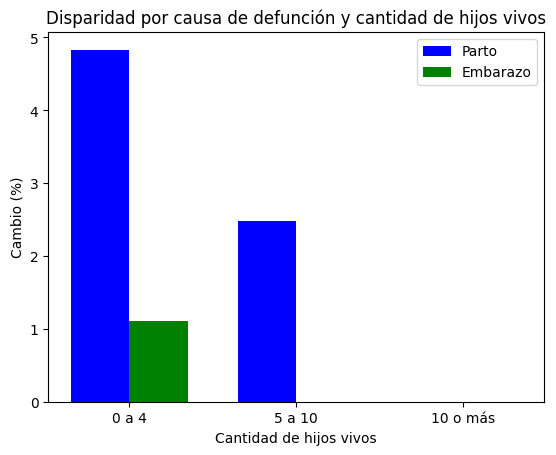

In [22]:
cuantos_hijos = ['0 a 4', '5 a 10', '10 o más']
parto_values = [disparidad['0 a 4'][0], disparidad['5 a 10'][0], disparidad['10 o más'][0]]
embarazo_values = [disparidad['0 a 4'][1], disparidad['5 a 10'][1], disparidad['10 o más'][1]]

bar_width = 0.35

r1 = np.arange(len(cuantos_hijos))
r2 = [x + bar_width for x in r1]

plt.bar(r1, parto_values, color='b', width=bar_width, label='Parto')
plt.bar(r2, embarazo_values, color='g', width=bar_width, label='Embarazo')

plt.xlabel('Cantidad de hijos vivos')
plt.ylabel('Cambio (%)')
plt.title('Disparidad por causa de defunción y cantidad de hijos vivos')
plt.xticks([r + bar_width / 2 for r in range(len(cuantos_hijos))], cuantos_hijos)
plt.legend()
plt.show()


### Estado civil de la madre

In [23]:
df0 = df[df['Causa_Defunción'] == 0] # Parto
df1 = df[df['Causa_Defunción'] == 1] # Embarazo

In [24]:
df0['Estado_Civil_Madre'].value_counts()

1     18061
2     14216
99     2891
3       103
Name: Estado_Civil_Madre, dtype: int64

In [25]:
df1['Estado_Civil_Madre'].value_counts()

1     17225
2     16620
99     1054
3       372
Name: Estado_Civil_Madre, dtype: int64

In [26]:
# Nivel de educación de la madre - Universidad
disparidad = {}

estadoCivil = {1:'Soltera', 2:'Casada', 3:'Unión Libre'}

for n in estadoCivil:
    disparidad[n] = {}
    for c in causas:
        df_1 = df[df['Causa_Defunción'] == c] # causa de defunción
        df_1 = df_1[columnas + ['Causa_Defunción']]

        df_1['Estado_Civil_Madre'] = n # Universidad

        x_train, x_test, y_train, y_test = train_test_split(df_1.drop('Causa_Defunción', axis=1), df_1['Causa_Defunción'], test_size=0.3, random_state=42)
        y_correct = clf.predict(x_test)

        print("---------------------------------------------------------------------------")
        causa = ''
        if c == 0:
            causa = 'Parto'
        elif c == 1:
            causa = 'Embarazo'

        print("Causa de defunción: ", causa)
        print("Estado civil de la madre: ", estadoCivil[n])
        
        print('Predicción: ', y_correct)
        print('Realidad: ', y_test.values)
        #print("Cambio: ", (y_correct != y_test).sum() / len(y_test) * 100, "%")
        cambio = (y_correct != y_test).sum() / len(y_test) * 100
        print("Cambio: ", cambio, "%")
        disparidad[n][c] = cambio



---------------------------------------------------------------------------
Causa de defunción:  Parto
Estado civil de la madre:  Soltera
Predicción:  [0 0 0 ... 0 0 0]
Realidad:  [0 0 0 ... 0 0 0]
Cambio:  4.252504252504252 %
---------------------------------------------------------------------------
Causa de defunción:  Embarazo
Estado civil de la madre:  Soltera
Predicción:  [0 1 0 ... 1 1 1]
Realidad:  [1 1 1 ... 1 1 1]
Cambio:  10.272160272160272 %
---------------------------------------------------------------------------
Causa de defunción:  Parto
Estado civil de la madre:  Casada
Predicción:  [0 0 0 ... 0 0 0]
Realidad:  [0 0 0 ... 0 0 0]
Cambio:  5.178605178605179 %
---------------------------------------------------------------------------
Causa de defunción:  Embarazo
Estado civil de la madre:  Casada
Predicción:  [0 1 0 ... 1 1 1]
Realidad:  [1 1 1 ... 1 1 1]
Cambio:  6.066906066906067 %
---------------------------------------------------------------------------
Causa de de

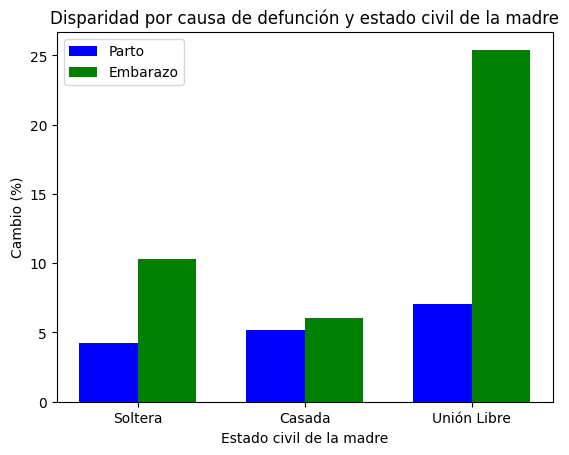

In [27]:
estados = ['Soltera', 'Casada', 'Unión Libre']
parto_values = [disparidad[1][0], disparidad[2][0], disparidad[3][0]]
embarazo_values = [disparidad[1][1], disparidad[2][1], disparidad[3][1]]

bar_width = 0.35

r1 = np.arange(len(estados))
r2 = [x + bar_width for x in r1]

plt.bar(r1, parto_values, color='b', width=bar_width, label='Parto')
plt.bar(r2, embarazo_values, color='g', width=bar_width, label='Embarazo')

plt.xlabel('Estado civil de la madre')
plt.ylabel('Cambio (%)')
plt.title('Disparidad por causa de defunción y estado civil de la madre')
plt.xticks([r + bar_width / 2 for r in range(len(estados))], estados)
plt.legend()
plt.show()

### Edad de la madre

#### Exploración de la variable de edad de la madre

In [28]:
df0 = df[df['Causa_Defunción'] == 0]
df1 = df[df['Causa_Defunción'] == 1]

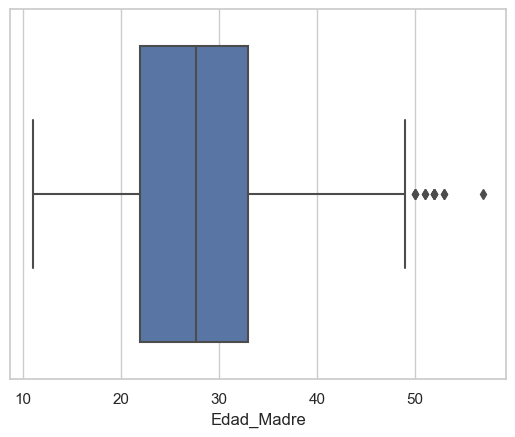

In [30]:
import seaborn as sns

df0['Edad_Madre'].value_counts()
# diagrama de tendencia central
sns.set(style="whitegrid")
ax = sns.boxplot(x=df0["Edad_Madre"])

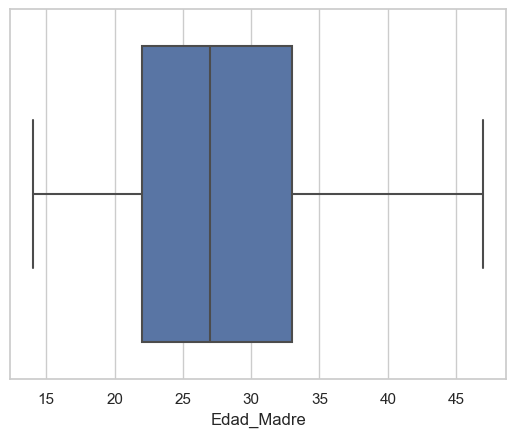

In [31]:
df1['Edad_Madre'].value_counts()
# diagrama de tendencia central
ax = sns.boxplot(x=df1["Edad_Madre"])



#### Comparación de rangos en la edad de la madre

In [32]:
edades = {
    '11-20': (11, 20),
    '21-30': (21, 30),
    '31-40': (31, 40),
    '41-50': (41, 50),
    '51+': (51, float('inf'))
}

disparidad = {}

for n in edades:
    ini, fin = edades[n]
    disparidad[n] = {}
    for c in causas:
        df_1 = df[df['Causa_Defunción'] == c]  # causa de defunción
        df_1 = df_1[columnas + ['Causa_Defunción']]
        df_1 = df_1[(df_1['Edad_Madre'] >= ini) & (df_1['Edad_Madre'] <= fin)]

        if len(df_1) == 0:
            continue  # Skip this iteration if there are no samples in the age range

        x_train, x_test, y_train, y_test = train_test_split(df_1.drop('Causa_Defunción', axis=1), df_1['Causa_Defunción'], test_size=0.3, random_state=42)

        if len(x_train) == 0 or len(x_test) == 0:
            continue  # Skip this iteration if there are not enough samples for training or testing

        y_correct = clf.predict(x_test)

        print("---------------------------------------------------------------------------")
        causa = ''
        if c == 0:
            causa = 'Parto'
        elif c == 1:
            causa = 'Embarazo'

        print("Causa de defunción: ", causa)
        print("Edad de la madre: ", n)

        print('Predicción: ', y_correct)
        print('Realidad: ', y_test.values)
        #print("Cambio: ", (y_correct != y_test).sum() / len(y_test) * 100, "%")
        cambio = (y_correct != y_test).sum() / len(y_test) * 100
        print("Cambio: ", cambio, "%")
        disparidad[n][c] = cambio


---------------------------------------------------------------------------
Causa de defunción:  Parto
Edad de la madre:  11-20
Predicción:  [0 0 0 ... 0 0 0]
Realidad:  [0 0 0 ... 0 0 0]
Cambio:  4.73186119873817 %
---------------------------------------------------------------------------
Causa de defunción:  Embarazo
Edad de la madre:  11-20
Predicción:  [1 1 1 ... 1 1 1]
Realidad:  [1 1 1 ... 1 1 1]
Cambio:  0.0 %
---------------------------------------------------------------------------
Causa de defunción:  Parto
Edad de la madre:  21-30
Predicción:  [0 0 0 ... 0 0 0]
Realidad:  [0 0 0 ... 0 0 0]
Cambio:  5.507580118979083 %
---------------------------------------------------------------------------
Causa de defunción:  Embarazo
Edad de la madre:  21-30
Predicción:  [1 1 1 ... 1 1 1]
Realidad:  [1 1 1 ... 1 1 1]
Cambio:  1.9919517102615696 %
---------------------------------------------------------------------------
Causa de defunción:  Parto
Edad de la madre:  31-40
Predicción: 

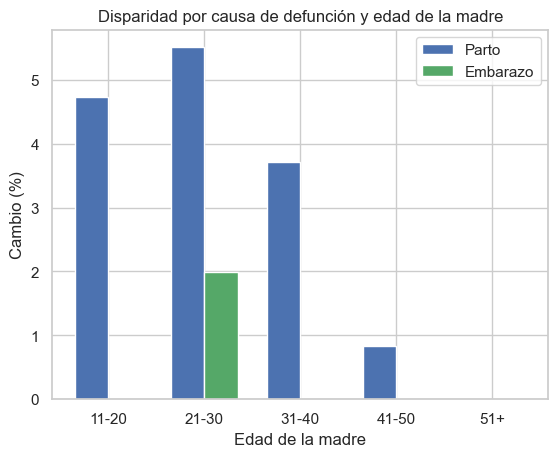

In [33]:
rangos_edad = ['11-20', '21-30', '31-40', '41-50', '51+']
parto_values = [disparidad['11-20'][0], disparidad['21-30'][0], disparidad['31-40'][0], disparidad['41-50'][0], disparidad['51+'][0]]
embarazo_values = [disparidad['11-20'][1], disparidad['21-30'][1], disparidad['31-40'][1], disparidad['41-50'][1], 0]

bar_width = 0.35

r1 = np.arange(len(rangos_edad))
r2 = [x + bar_width for x in r1]

plt.bar(r1, parto_values, color='b', width=bar_width, label='Parto')
plt.bar(r2, embarazo_values, color='g', width=bar_width, label='Embarazo')

plt.xlabel('Edad de la madre')
plt.ylabel('Cambio (%)')
plt.title('Disparidad por causa de defunción y edad de la madre')
plt.xticks([r + bar_width / 2 for r in range(len(rangos_edad))], rangos_edad)
plt.legend()
plt.show()

### Etnia de la madre

In [34]:
df0 = df[df['Causa_Defunción'] == 0]
df1 = df[df['Causa_Defunción'] == 1]

In [35]:
df0['Grupo_Etnico_Madre'].value_counts()

1     12317
2      8797
99     7016
3      3674
4      3051
5       383
6        19
7        14
Name: Grupo_Etnico_Madre, dtype: int64

In [36]:
df1['Grupo_Etnico_Madre'].value_counts()

1     11017
2      8940
3      5649
99     4797
4      4381
5       415
6        72
Name: Grupo_Etnico_Madre, dtype: int64

In [37]:
etnias = {
    1: 'Maya',
    2: 'Ladina/Mestiza',
    3: 'Indígena',
    4: 'No Indígena',
    5: 'Otra',
    6: 'Garífuna',
    7: 'Xinca'
}

disparidad = {}

for n in etnias:
    disparidad[n] = {}
    for c in causas:
        df_1 = df[df['Causa_Defunción'] == c] # causa de defunción
        df_1 = df_1[columnas + ['Causa_Defunción']]

        df_1['Grupo_Etnico_Madre'] = n # etnia

        x_train, x_test, y_train, y_test = train_test_split(df_1.drop('Causa_Defunción', axis=1), df_1['Causa_Defunción'], test_size=0.3, random_state=42)
        y_correct = clf.predict(x_test)

        print("---------------------------------------------------------------------------")
        causa = ''
        if c == 0:
            causa = 'Parto'
        elif c == 1:
            causa = 'Embarazo'

        print("Causa de defunción: ", causa)
        print("Etnia de la madre: ", etnias[n])
        
        print('Predicción: ', y_correct)
        print('Realidad: ', y_test.values)
        #print("Cambio: ", (y_correct != y_test).sum() / len(y_test) * 100, "%")
        cambio = (y_correct != y_test).sum() / len(y_test) * 100
        print("Cambio: ", cambio, "%")
        disparidad[n][c] = cambio

---------------------------------------------------------------------------
Causa de defunción:  Parto
Etnia de la madre:  Maya
Predicción:  [0 0 0 ... 0 0 0]
Realidad:  [0 0 0 ... 0 0 0]
Cambio:  4.507654507654508 %
---------------------------------------------------------------------------
Causa de defunción:  Embarazo
Etnia de la madre:  Maya
Predicción:  [0 1 0 ... 1 0 1]
Realidad:  [1 1 1 ... 1 1 1]
Cambio:  38.12133812133812 %
---------------------------------------------------------------------------
Causa de defunción:  Parto
Etnia de la madre:  Ladina/Mestiza
Predicción:  [0 0 0 ... 0 0 0]
Realidad:  [0 0 0 ... 0 0 0]
Cambio:  5.868455868455868 %
---------------------------------------------------------------------------
Causa de defunción:  Embarazo
Etnia de la madre:  Ladina/Mestiza
Predicción:  [0 1 0 ... 1 1 1]
Realidad:  [1 1 1 ... 1 1 1]
Cambio:  21.895671895671896 %
---------------------------------------------------------------------------
Causa de defunción:  Parto
Et

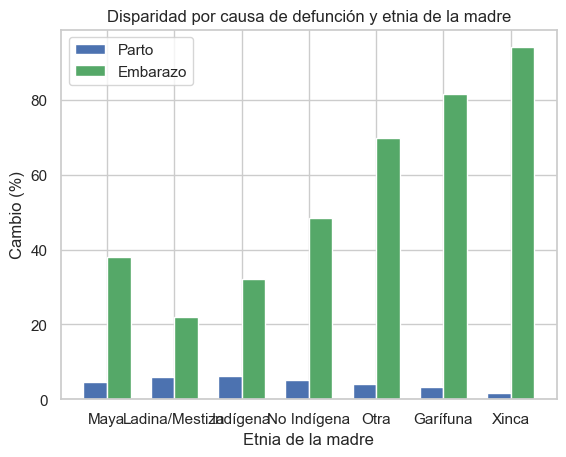

In [38]:
etnias = ['Maya', 'Ladina/Mestiza', 'Indígena', 'No Indígena', 'Otra', 'Garífuna', 'Xinca']
parto_values = [disparidad[1][0], disparidad[2][0], disparidad[3][0], disparidad[4][0], disparidad[5][0], disparidad[6][0], disparidad[7][0]]
embarazo_values = [disparidad[1][1], disparidad[2][1], disparidad[3][1], disparidad[4][1], disparidad[5][1], disparidad[6][1], disparidad[7][1]]

bar_width = 0.35

r1 = np.arange(len(etnias))
r2 = [x + bar_width for x in r1]

plt.bar(r1, parto_values, color='b', width=bar_width, label='Parto')
plt.bar(r2, embarazo_values, color='g', width=bar_width, label='Embarazo')

plt.xlabel('Etnia de la madre')
plt.ylabel('Cambio (%)')
plt.title('Disparidad por causa de defunción y etnia de la madre')
plt.xticks([r + bar_width / 2 for r in range(len(etnias))], etnias)
plt.legend()
plt.show()